# Analysis

## Preamble

In [1]:
from pathlib import Path

train_path = Path("titanic-data", "train.csv")
test_path = Path("titanic-data", "test.csv")

In [2]:
import pandas as pd

train_df = pd.read_csv(train_path)
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Data Dictionary provided here: https://www.kaggle.com/competitions/titanic/data?select=train.csv

`Survived`: binary indicator of whether passenger (identified by `PassengerId` column) survived the Titanic tragedy

`Pclass`: ticket class, where 1 is first class, 2 is second class, and 3 is third class.

`Name`: Name of passenger

`Sex`: sex of the passenger

`Age`: age of the passenger

`SibSp`: number of siblings or spouses aboard the Titanic

`Parch`: number of parents or children aboard the Titanic

`Ticket`: ticket number

`Fare`: passeger fare

`cabin`: cabin number

`embarked`: port of embarkation

I'm not a huge fan of these column names, so I'm going to rename them.

In [4]:
def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    "Rename columns for my personal taste."
    return df.rename(columns={
        "PassengerId": "passenger_id",
        "Survived": "did_survive",
        "Pclass": "ticket_class",
        "Name": "passenger_name",
        "Sex": "sex",
        "Age": "age",
        "SibSp": "sibling_spouse_count",
        "Parch": "parent_child_count",
        "Ticket": "ticket_number",
        "Fare": "ticket_fare",
        "Cabin": "cabin_number",
        "Embarked": "embarkation_port",
    })

def submission_rename(df: pd.DataFrame) -> pd.DataFrame:
    """A certain schema is expected for the submission, so this function will need to be run on whatever data I submit to Kaggle."""
    return df.rename(
        columns={
            "did_survive": "Survived",
            "passenger_id": "PassengerId",
        }
    )[["PassengerId", "Survived"]]

train_df = rename_columns(train_df)
train_df.columns

Index(['passenger_id', 'did_survive', 'ticket_class', 'passenger_name', 'sex',
       'age', 'sibling_spouse_count', 'parent_child_count', 'ticket_number',
       'ticket_fare', 'cabin_number', 'embarkation_port'],
      dtype='object')

In [5]:
train_df.groupby("cabin_number", dropna=False).passenger_id.nunique().sort_values(ascending=False)

cabin_number
NaN            687
C23 C25 C27      4
B96 B98          4
G6               4
E101             3
              ... 
C62 C64          1
C54              1
B39              1
C50              1
A10              1
Name: passenger_id, Length: 148, dtype: int64

In [6]:
train_df.passenger_name.unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

There are a few columns right off the bat which I expect should have no predictive power: `passenger_name`, `passenger_id`, and `ticket_number`.

It is plausible that `cabin_number` could have predictive power, but that might require spatial information about the titanic to be more useful. That being said, noting whether the passenger *has* a cabin, or noting the cabin alphabetical prefix, could yield some interesting results, though I suspect high correlation with `ticket_class`.

I'm not so certain about `embarkation_port`, so I'll at least take a look at the distribution there.

## EDA

Let's make some functions which will make downstream analysis easier.

In [7]:
from plotnine import *
from statsmodels.stats.proportion import proportion_confint
from mizani.formatters import percent_format

In [8]:
def plot_survival_ci(df: pd.DataFrame, group: str) -> ggplot:
    "Plot the survival rate and confidence interval for each group."
    group_readable = " ".join(group.split("_")).title()
    return (
        ggplot(df.reset_index(), aes(x=group, y="survival_rate", ymin="lower", ymax="upper"))
        + geom_errorbar()
        + geom_point()
        + labs(
            title=f"P[Survival | {group_readable}]",
            subtitle="95% Binomial CI",
            y="Likelihood of Survival",
            x=group_readable,
        )
        + scale_y_continuous(labels=percent_format())
    )

def create_survival_df(df: pd.DataFrame, group: str) -> pd.DataFrame:
    "Create a DataFrame with survival rate for each group."
    return (
        df.groupby(group)
        .did_survive.agg(["sum", "count"])
        .assign(survival_rate=lambda x: x["sum"] / x["count"])
        .rename(columns={"sum": "survivors", "count": "passengers"})
    )

def calc_survival_ci(df: pd.DataFrame, method="beta", alpha=0.05) -> pd.DataFrame:
    "Calculate the survival rate and confidence interval for each group."
    lower, upper = proportion_confint(df["survivors"], df["passengers"], method=method, alpha=alpha)
    return df.assign(lower=lower, upper=upper)

### Port of Embarkation

In [9]:
embark_survival_rates = create_survival_df(train_df, "embarkation_port")
embark_survival_rates

,survivors,passengers,survival_rate
embarkation_port,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


Curiously, It does seem that Cherbourg had a higher survival rate thatn Queenstown or Southampton. Is that difference significant?

In [10]:
embark_survival_rates = calc_survival_ci(embark_survival_rates)
embark_survival_rates

,survivors,passengers,survival_rate,lower,upper
embarkation_port,,,,,
C,93,168,0.553571,0.475048,0.630171
Q,30,77,0.389610,0.280462,0.507520
S,217,644,0.336957,0.300493,0.374923


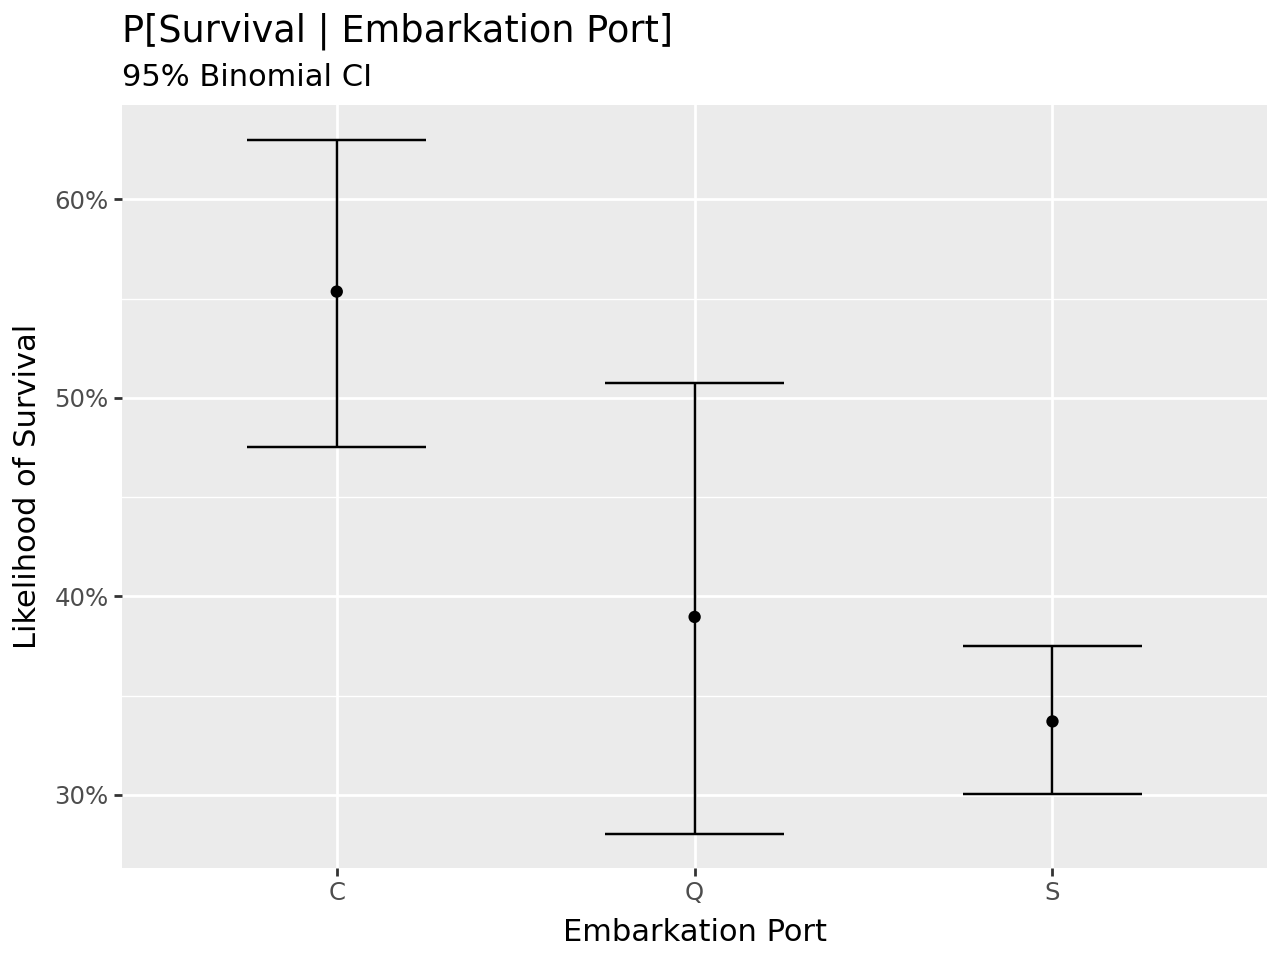

In [11]:
embarkation_ci_fig = plot_survival_ci(embark_survival_rates, "embarkation_port")
embarkation_ci_fig.show()

It does look like Port of Embarkation matters significantly when comparing `C` to `S` by about 20%, but it wouldn't surprise me if it correlates strongly with other features. We'll One Hot Encode this feature, though, and see how it appears in feature importance measures.

### Age, Sibling/Spouse, Parent/Child, Ticket Fare

I'm also curious how `age`, `sibling_spouse_count`, `parent_child_count`, and `ticket_fare` correlate with survival. Let's try using point biserial correlation coefficient.

In [12]:
from scipy.stats import pointbiserialr

y = "did_survive"
X = ["age", "sibling_spouse_count", "parent_child_count", "ticket_fare"]
for x in X:
    stat, p = pointbiserialr(train_df[x].fillna(0), train_df[y])
    is_significant_flag = "not " if p > 0.05 else ""
    print(f"Correlation between {x} and {y} is {stat}, with a p-value of {p}, which is {is_significant_flag}significant.")

Correlation between age and did_survive is 0.010539215871285632, with a p-value of 0.7534004969396125, which is not significant.
Correlation between sibling_spouse_count and did_survive is -0.035322498885735625, with a p-value of 0.29224392869829086, which is not significant.
Correlation between parent_child_count and did_survive is 0.08162940708348349, with a p-value of 0.014799245374727947, which is significant.
Correlation between ticket_fare and did_survive is 0.25730652238496243, with a p-value of 6.1201893419246185e-15, which is significant.


So, generally, age doesn't matter, though that may be because only certain *extremes* in age matter. Similarly, sibling or spouse count doesn't matter. However, parent or child count *does* matter, though only slightly, as does ticket fare, though I would be surprised if ticket fare didn't correlate extremely with passenger class.

I suspect that sex is important for the parent/child count flag to actually matter, and maybe age as well.

### Cabin Number

In [13]:
train_df.cabin_number.str.split(" ", expand=True)

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,C85,None,None,None
2,NaN,NaN,NaN,NaN
3,C123,None,None,None
4,NaN,NaN,NaN,NaN
...,...,...,...,...
886,NaN,NaN,NaN,NaN
887,B42,None,None,None
888,NaN,NaN,NaN,NaN
889,C148,None,None,None


It looks like some passengers had multiple cabins. They were also probably had superior ticket classes than not.

In [14]:
train_df = train_df.assign(
    cabin_count=(
        train_df.cabin_number.str.split(" ", expand=True)
        .map(lambda x: 1 if not pd.isnull(x) else 0)
        .sum(axis=1)
    )
)
train_df.cabin_count.value_counts()

cabin_count
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [15]:
train_df["cabin_letter"] = train_df.cabin_number.str[0].fillna("N/A")
train_df.cabin_letter.value_counts().sort_index()

cabin_letter
A       15
B       47
C       59
D       33
E       32
F       13
G        4
N/A    687
T        1
Name: count, dtype: int64

In [16]:
cabin_letter_survival_rates = create_survival_df(train_df, "cabin_letter")
cabin_letter_survival_rates

,survivors,passengers,survival_rate
cabin_letter,,,
A,7,15,0.466667
B,35,47,0.744681
C,35,59,0.593220
D,25,33,0.757576
E,24,32,0.750000
F,8,13,0.615385
G,2,4,0.500000
N/A,206,687,0.299854
T,0,1,0.000000


In [17]:
cabin_letter_survival_rates = calc_survival_ci(cabin_letter_survival_rates)
cabin_letter_survival_rates

,survivors,passengers,survival_rate,lower,upper
cabin_letter,,,,,
A,7,15,0.466667,0.212667,0.734139
B,35,47,0.744681,0.596505,0.860551
C,35,59,0.593220,0.457452,0.719304
D,25,33,0.757576,0.577411,0.889077
E,24,32,0.750000,0.565951,0.885384
F,8,13,0.615385,0.315778,0.861421
G,2,4,0.500000,0.067586,0.932414
N/A,206,687,0.299854,0.265786,0.335652
T,0,1,0.000000,0.000000,0.975000


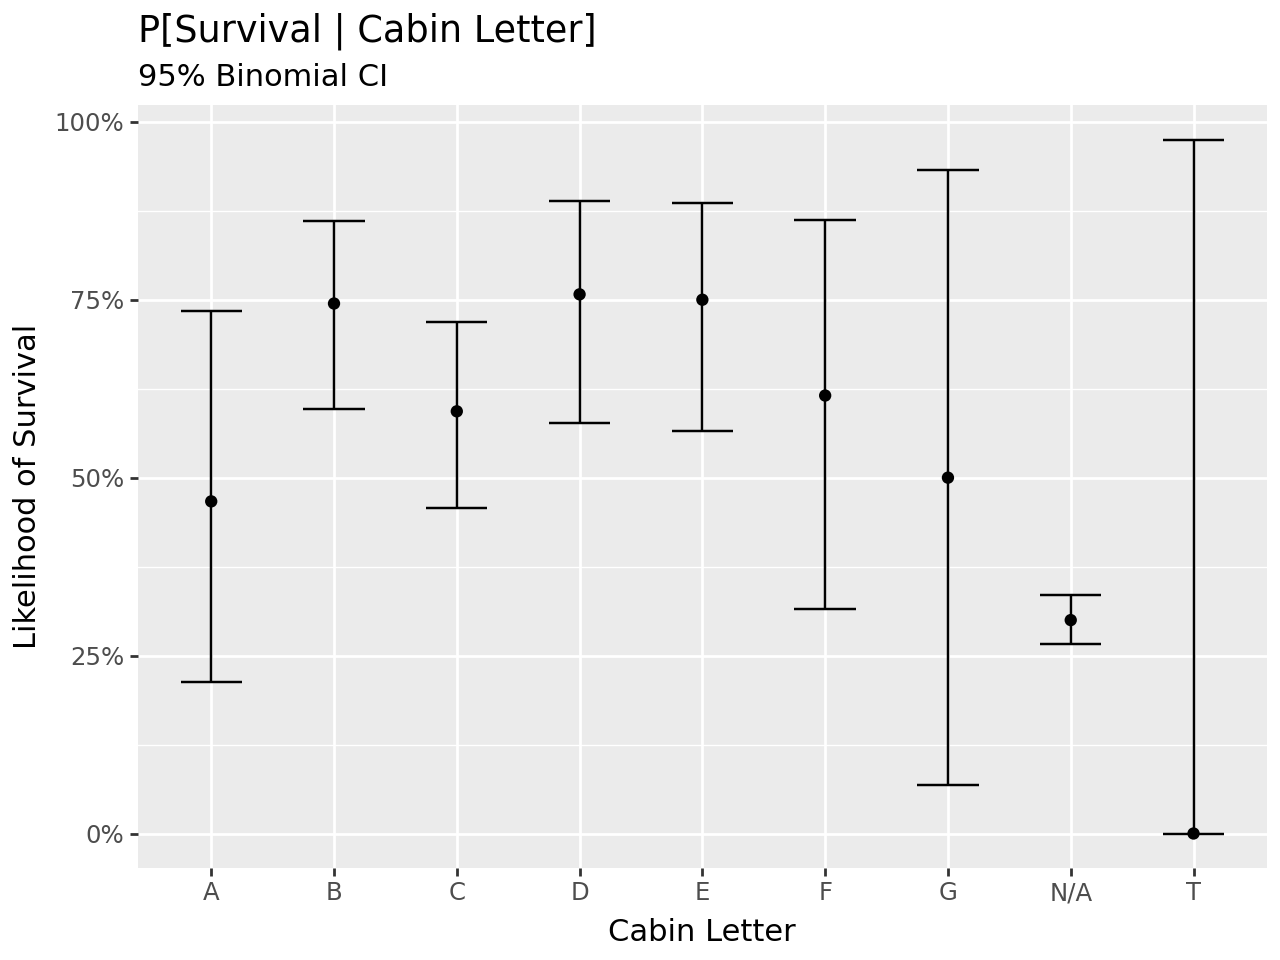

In [18]:
plot_survival_ci(cabin_letter_survival_rates, "cabin_letter").show()

Generally, having a cabin would give you a better chance of survival. Again, I expect this correlates strongly with ticket class.

In [19]:
cabin_count_survival_rates = create_survival_df(train_df, "cabin_count")
cabin_count_survival_rates

,survivors,passengers,survival_rate
cabin_count,,,
0,206,687,0.299854
1,122,180,0.677778
2,9,16,0.562500
3,3,6,0.500000
4,2,2,1.000000


In [20]:
cabin_count_survival_rates = calc_survival_ci(cabin_count_survival_rates)
cabin_count_survival_rates

,survivors,passengers,survival_rate,lower,upper
cabin_count,,,,,
0,206,687,0.299854,0.265786,0.335652
1,122,180,0.677778,0.604211,0.745375
2,9,16,0.562500,0.298777,0.802466
3,3,6,0.500000,0.118117,0.881883
4,2,2,1.000000,0.158114,1.000000


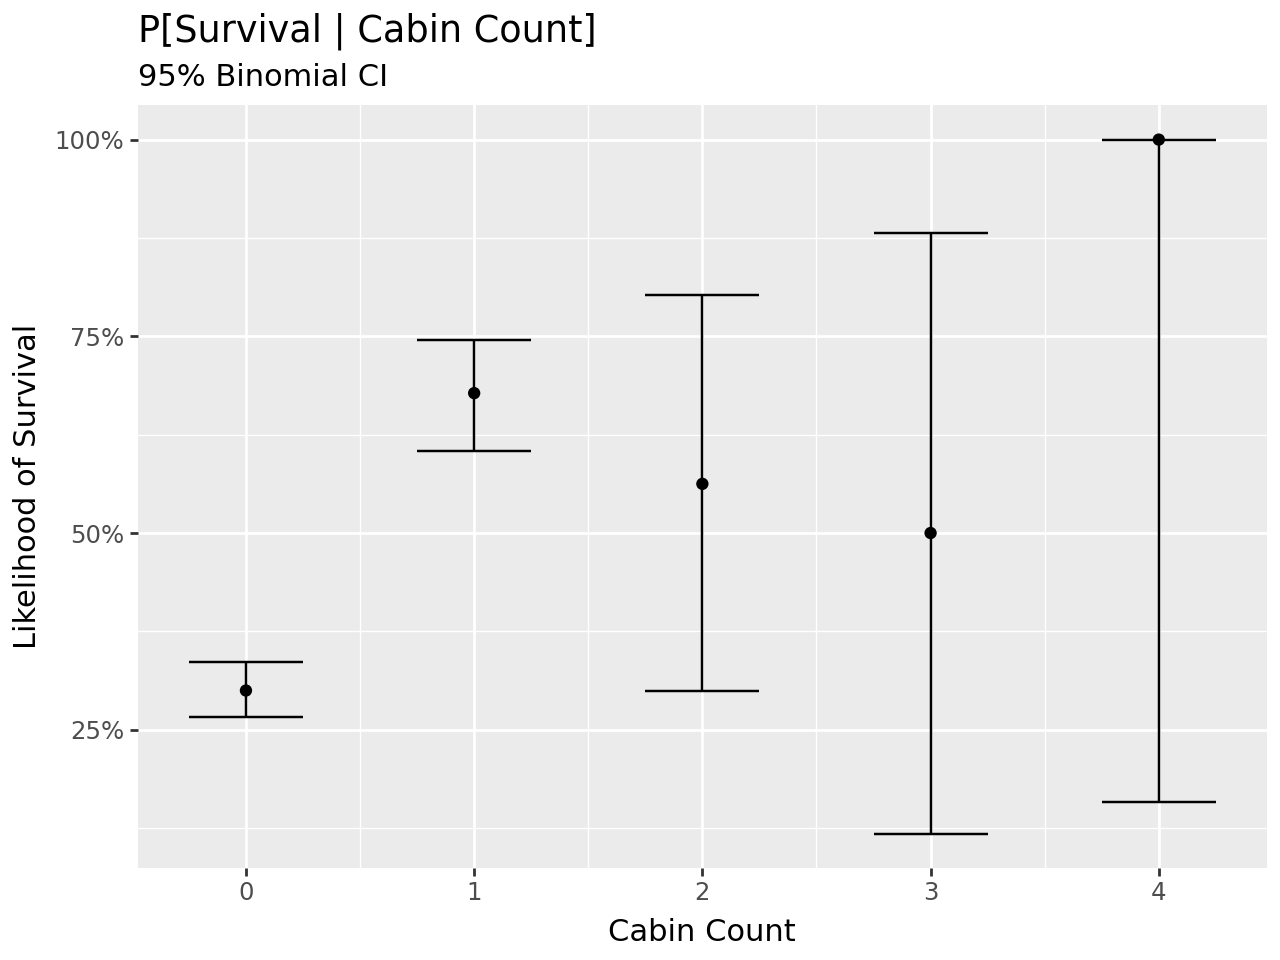

In [21]:
plot_survival_ci(cabin_count_survival_rates, "cabin_count").show()

Since having 2-4 cabins is such an extreme outlier, there is no statistically significant claim that can be made about those groups, but since having even 1 cabin results in an average survival rate increase of about 30-35%, and since the average survival rate of 2-4 cabins is still much higher than average, it seems reasonable to conclude that having at least 1 cabin is highly preferable to having none. Does the statistics of this change at all if we group the 2-4 cabin group into one?

In [22]:
train_df = train_df.assign(
    clean_cabin_count=train_df.cabin_count.apply(lambda x: str(x) if x < 2 else "2-4")
)
train_df.clean_cabin_count.value_counts()

clean_cabin_count
0      687
1      180
2-4     24
Name: count, dtype: int64

In [23]:
clean_cabin_count_survival_rates = create_survival_df(train_df, "clean_cabin_count")
clean_cabin_count_survival_rates

,survivors,passengers,survival_rate
clean_cabin_count,,,
0,206,687,0.299854
1,122,180,0.677778
2-4,14,24,0.583333


In [24]:
clean_cabin_count_survival_rates = calc_survival_ci(clean_cabin_count_survival_rates)
clean_cabin_count_survival_rates

,survivors,passengers,survival_rate,lower,upper
clean_cabin_count,,,,,
0,206,687,0.299854,0.265786,0.335652
1,122,180,0.677778,0.604211,0.745375
2-4,14,24,0.583333,0.366431,0.778903


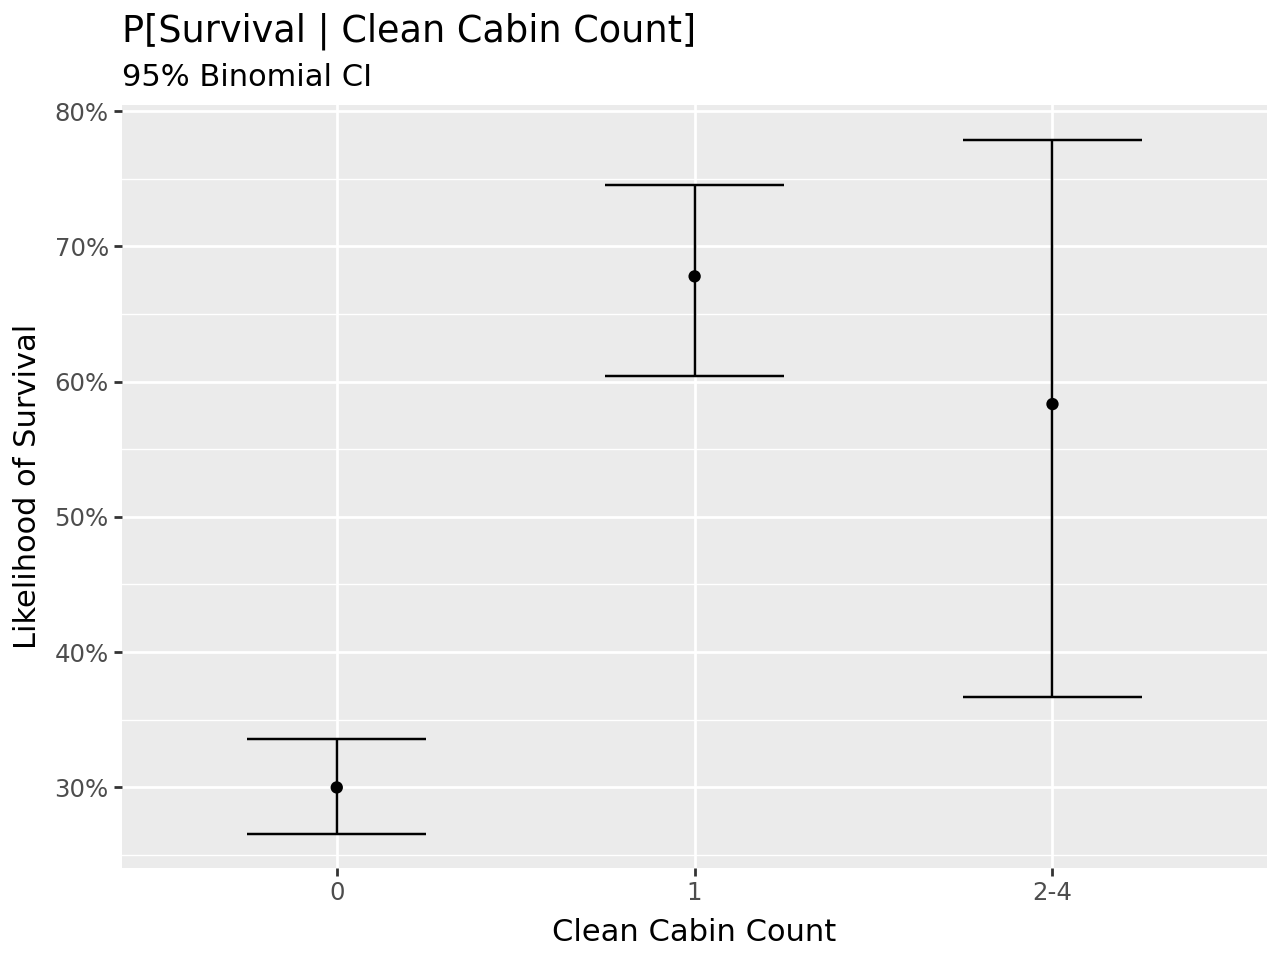

In [25]:
plot_survival_ci(clean_cabin_count_survival_rates, "clean_cabin_count").show()

Well, grouping together helps a little bit, but not by a whole lot. Still, at least the 2-4 CI no longer overlaps with the 0 cabin count.

### Ticket Class

In [26]:
ticket_class_survival_rates = create_survival_df(train_df, "ticket_class")
ticket_class_survival_rates

,survivors,passengers,survival_rate
ticket_class,,,
1,136,216,0.629630
2,87,184,0.472826
3,119,491,0.242363


In [27]:
ticket_class_survival_rates = calc_survival_ci(ticket_class_survival_rates)
ticket_class_survival_rates

,survivors,passengers,survival_rate,lower,upper
ticket_class,,,,,
1,136,216,0.629630,0.561486,0.694161
2,87,184,0.472826,0.398929,0.547613
3,119,491,0.242363,0.205090,0.282770


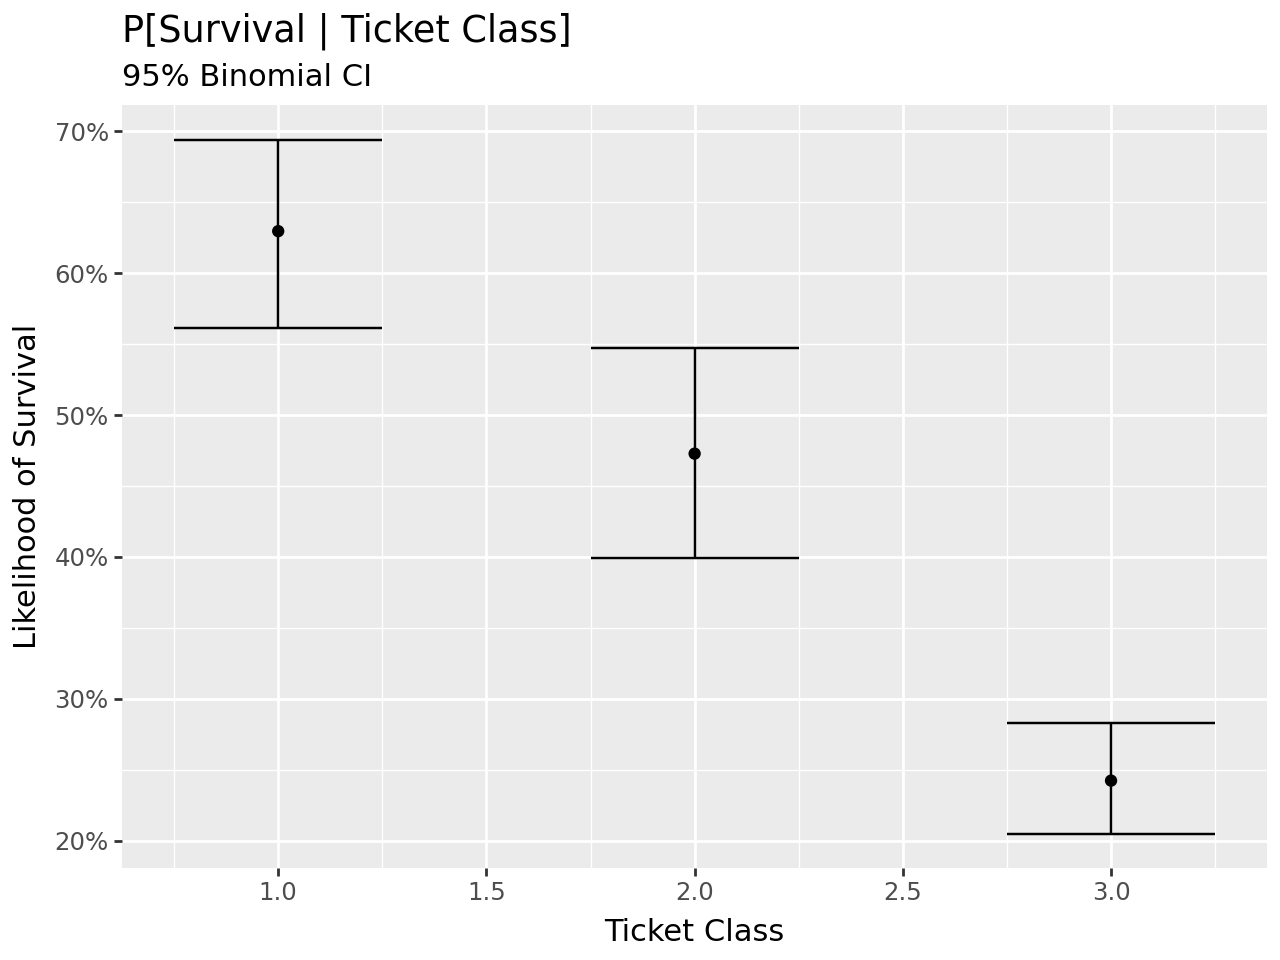

In [28]:
plot_survival_ci(ticket_class_survival_rates, "ticket_class").show()

Well isn't *that* a stark feature. Definitely should be included in whatever feature set we decide on. While it would be tempting to One Hot Encode this, the fact is that this isn't a nominal variable, but an ordinal one, so we should probably use scikit-learn's `OrdinalEncoder`.

### Sex

In [29]:
sex_survival_rates = create_survival_df(train_df, "sex")
sex_survival_rates

,survivors,passengers,survival_rate
sex,,,
female,233,314,0.742038
male,109,577,0.188908


In [30]:
sex_survival_rates = calc_survival_ci(sex_survival_rates)
sex_survival_rates

,survivors,passengers,survival_rate,lower,upper
sex,,,,,
female,233,314,0.742038,0.689908,0.789537
male,109,577,0.188908,0.157763,0.223277


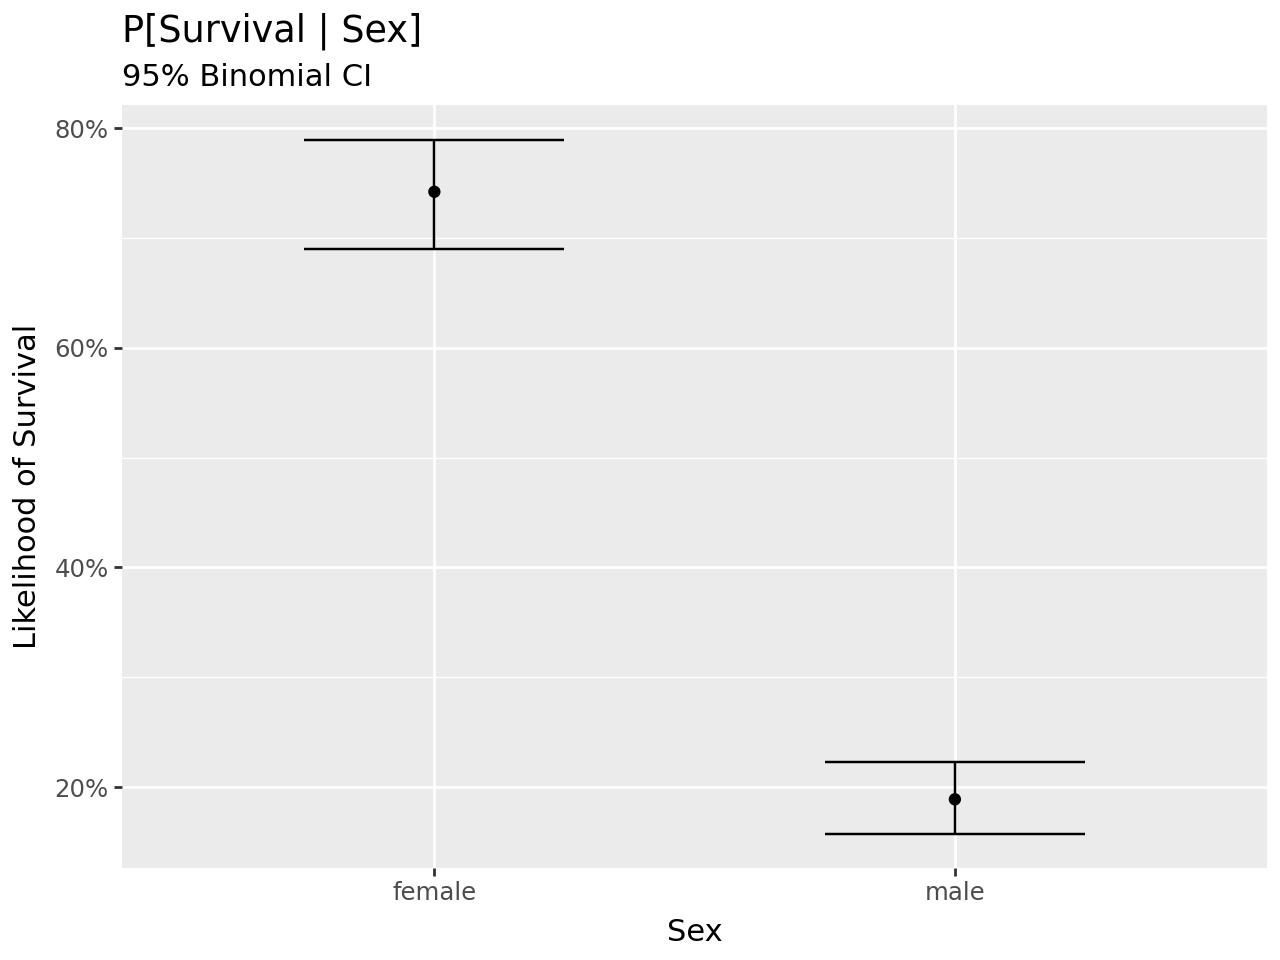

In [31]:
plot_survival_ci(sex_survival_rates, "sex")

No surprises here. "Women and children first", and all that.

### Age

In [32]:
train_df.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

This is a bit of a weird one, since we saw earlier that there is no linear correlation between age and survival rate. I bet if we bin the ages, though, we'll get something useful.


In [33]:
train_df = train_df.assign(clean_age=pd.cut(train_df.age, bins=[0, 5, 12, 18, 25, 50, 100], labels=["young child", "child", "teenager", "young adult", "adult", "elderly"]))
train_df.clean_age.value_counts()

clean_age
adult          349
young adult    162
teenager        70
elderly         64
young child     44
child           25
Name: count, dtype: int64

In [34]:
train_df.clean_age.isnull().sum()

177

In [35]:
train_df.age.isnull().sum()

177

Brilliant. There are null ages in there. We'll have to clean those up later, probably with interpolation.

In [36]:
clean_age_survival_rates = create_survival_df(train_df, "clean_age")
clean_age_survival_rates

C:\Users\pwiss\AppData\Local\Temp\ipykernel_12860\1351292881.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,survivors,passengers,survival_rate
clean_age,,,
young child,31,44,0.704545
child,9,25,0.360000
teenager,30,70,0.428571
young adult,54,162,0.333333
adult,144,349,0.412607
elderly,22,64,0.343750


In [37]:
clean_age_survival_rates = calc_survival_ci(clean_age_survival_rates)
clean_age_survival_rates

,survivors,passengers,survival_rate,lower,upper
clean_age,,,,,
young child,31,44,0.704545,0.547978,0.832356
child,9,25,0.360000,0.179717,0.574794
teenager,30,70,0.428571,0.310868,0.552513
young adult,54,162,0.333333,0.261327,0.411566
adult,144,349,0.412607,0.360460,0.466250
elderly,22,64,0.343750,0.229463,0.473023


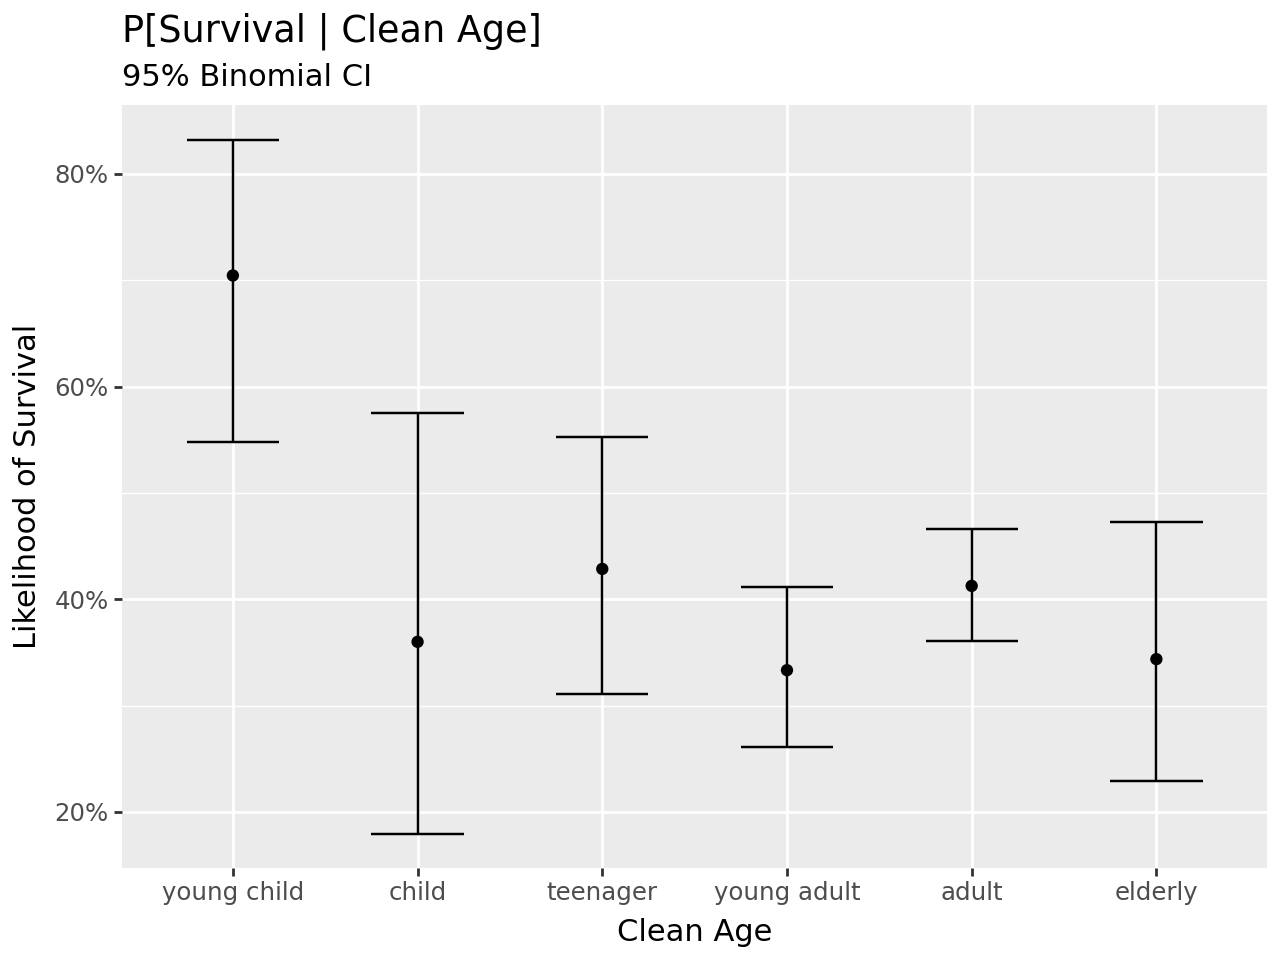

In [38]:
plot_survival_ci(clean_age_survival_rates, "clean_age").show()

Kind of depressing. Young children less than five years old had a pretty high chance of survival, but above that, it doesn't seem to help much. So, if we change this to just identify young children as a feature, instead, what do we get?

C:\Users\pwiss\AppData\Local\Temp\ipykernel_12860\1351292881.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


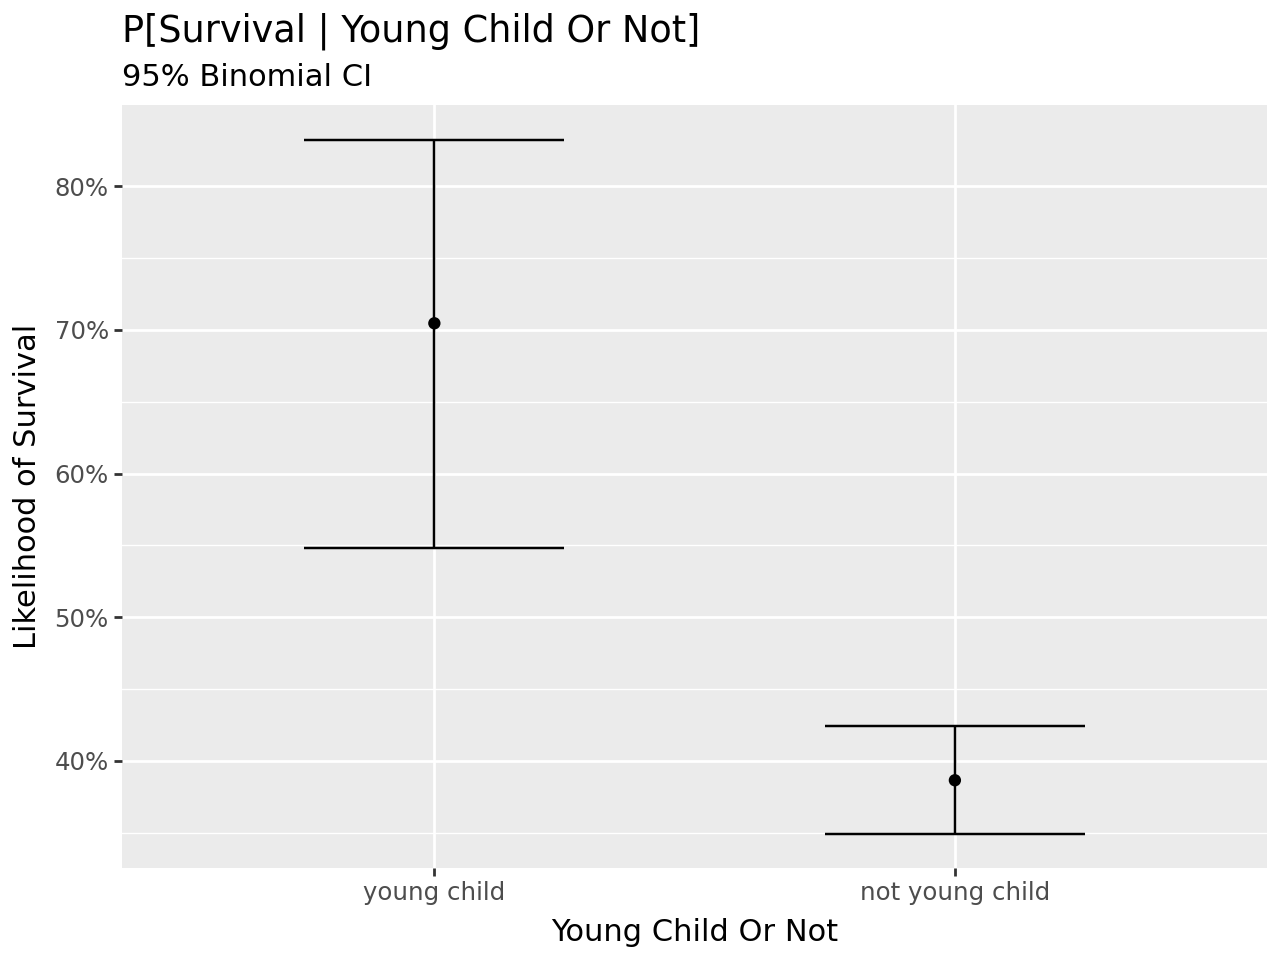

In [39]:
train_df = train_df.assign(young_child_or_not=pd.cut(train_df.age, bins=[0, 5, 100], labels=["young child", "not young child"]))
clean_age_survival_rates = create_survival_df(train_df, "young_child_or_not")
clean_age_survival_rates = calc_survival_ci(clean_age_survival_rates)
plot_survival_ci(clean_age_survival_rates, "young_child_or_not").show()

Seems like a useful enough feature. Ship it!

### Combining Age and Sex

In [40]:
train_df = train_df.assign(demographic=train_df.apply(lambda x: x.sex if x.young_child_or_not != "young child" else x.young_child_or_not, axis=1))
train_df.demographic.value_counts()

demographic
male           554
female         293
young child     44
Name: count, dtype: int64

In [41]:
demographic_survival_rates = create_survival_df(train_df, "demographic")
demographic_survival_rates

,survivors,passengers,survival_rate
demographic,,,
female,217,293,0.740614
male,94,554,0.169675
young child,31,44,0.704545


In [42]:
demographic_survival_rates = calc_survival_ci(demographic_survival_rates)
demographic_survival_rates

,survivors,passengers,survival_rate,lower,upper
demographic,,,,,
female,217,293,0.740614,0.686442,0.789847
male,94,554,0.169675,0.139348,0.203574
young child,31,44,0.704545,0.547978,0.832356


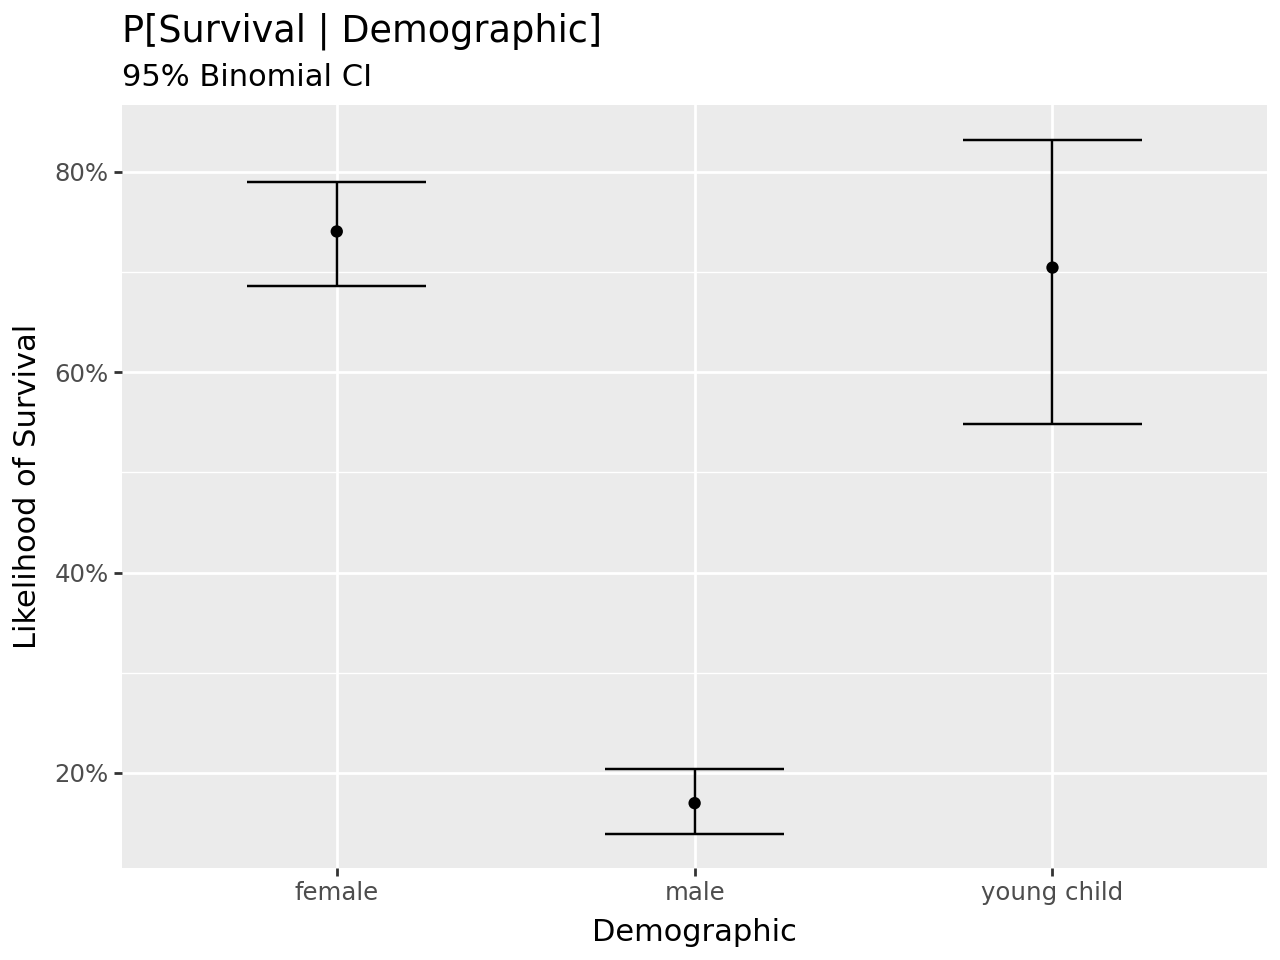

In [43]:
plot_survival_ci(demographic_survival_rates, "demographic").show()

### Family Size

In [61]:
train_df = train_df.assign(
    family_size=train_df.sibling_spouse_count + train_df.parent_child_count
)
train_df.family_size.value_counts()

family_size
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: count, dtype: int64

In [62]:
family_size_survival_rates = create_survival_df(train_df, "family_size")
family_size_survival_rates

,survivors,passengers,survival_rate
family_size,,,
0,163,537,0.303538
1,89,161,0.552795
2,59,102,0.578431
3,21,29,0.724138
4,3,15,0.200000
5,3,22,0.136364
6,4,12,0.333333
7,0,6,0.000000
10,0,7,0.000000


In [63]:
family_size_survival_rates = calc_survival_ci(family_size_survival_rates)
family_size_survival_rates

,survivors,passengers,survival_rate,lower,upper
family_size,,,,,
0,163,537,0.303538,0.264892,0.344362
1,89,161,0.552795,0.472524,0.631086
2,59,102,0.578431,0.476610,0.675576
3,21,29,0.724138,0.527616,0.872660
4,3,15,0.200000,0.043312,0.480891
5,3,22,0.136364,0.029056,0.349122
6,4,12,0.333333,0.099246,0.651124
7,0,6,0.000000,0.000000,0.459258
10,0,7,0.000000,0.000000,0.409616


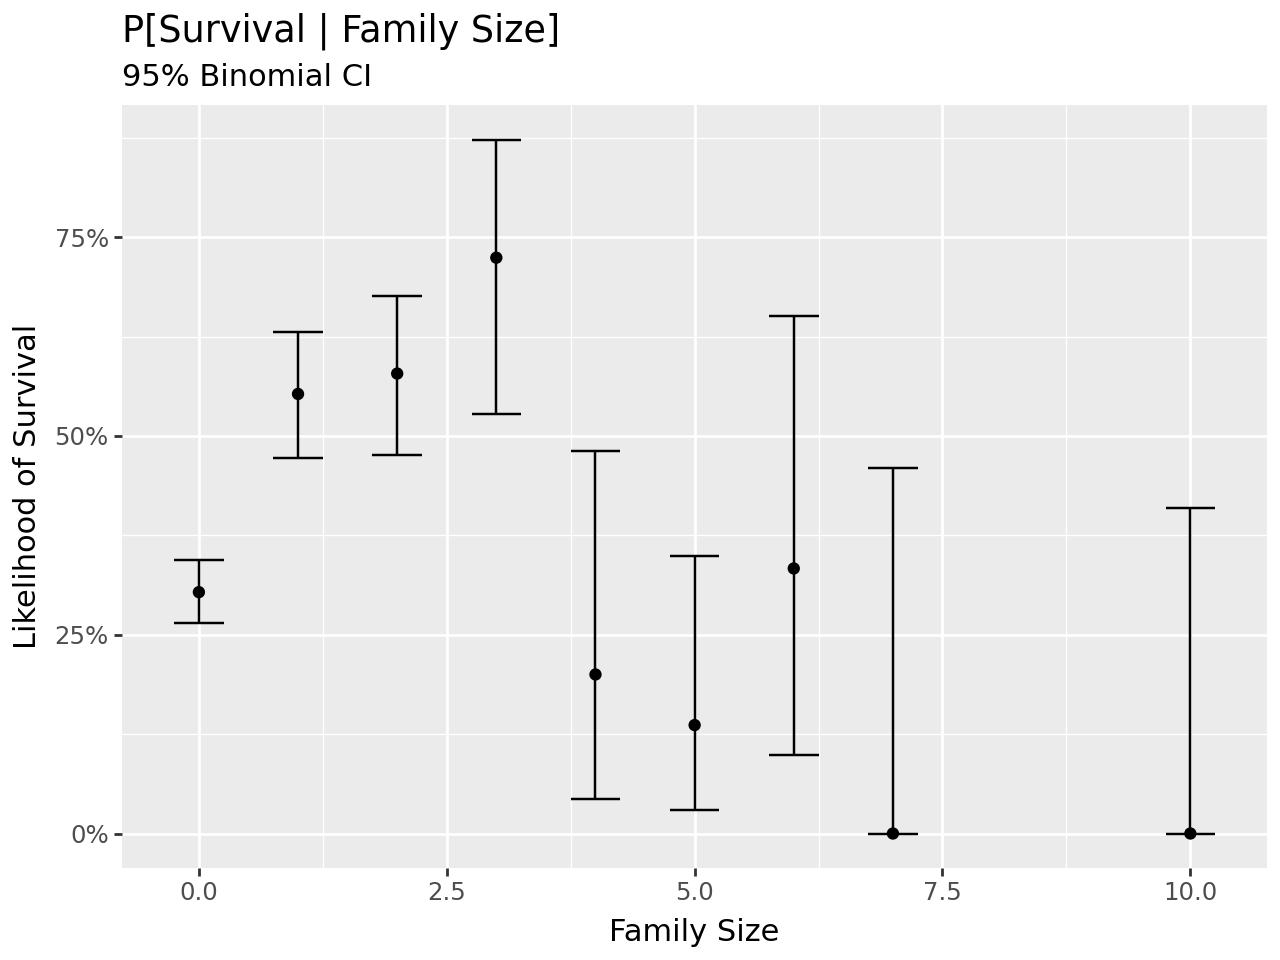

In [64]:
plot_survival_ci(family_size_survival_rates, "family_size").show()

In [65]:
train_df = train_df.assign(
    is_alone=train_df.family_size.map(lambda x: 1 if x == 0 else 0)
)
train_df.is_alone.value_counts()

is_alone
1    537
0    354
Name: count, dtype: int64

In [66]:
is_alone_survival_rates = create_survival_df(train_df, "is_alone")
is_alone_survival_rates

,survivors,passengers,survival_rate
is_alone,,,
0,179,354,0.505650
1,163,537,0.303538


In [68]:
is_alone_survival_rates = calc_survival_ci(is_alone_survival_rates)
is_alone_survival_rates

,survivors,passengers,survival_rate,lower,upper
is_alone,,,,,
0,179,354,0.505650,0.452297,0.558907
1,163,537,0.303538,0.264892,0.344362


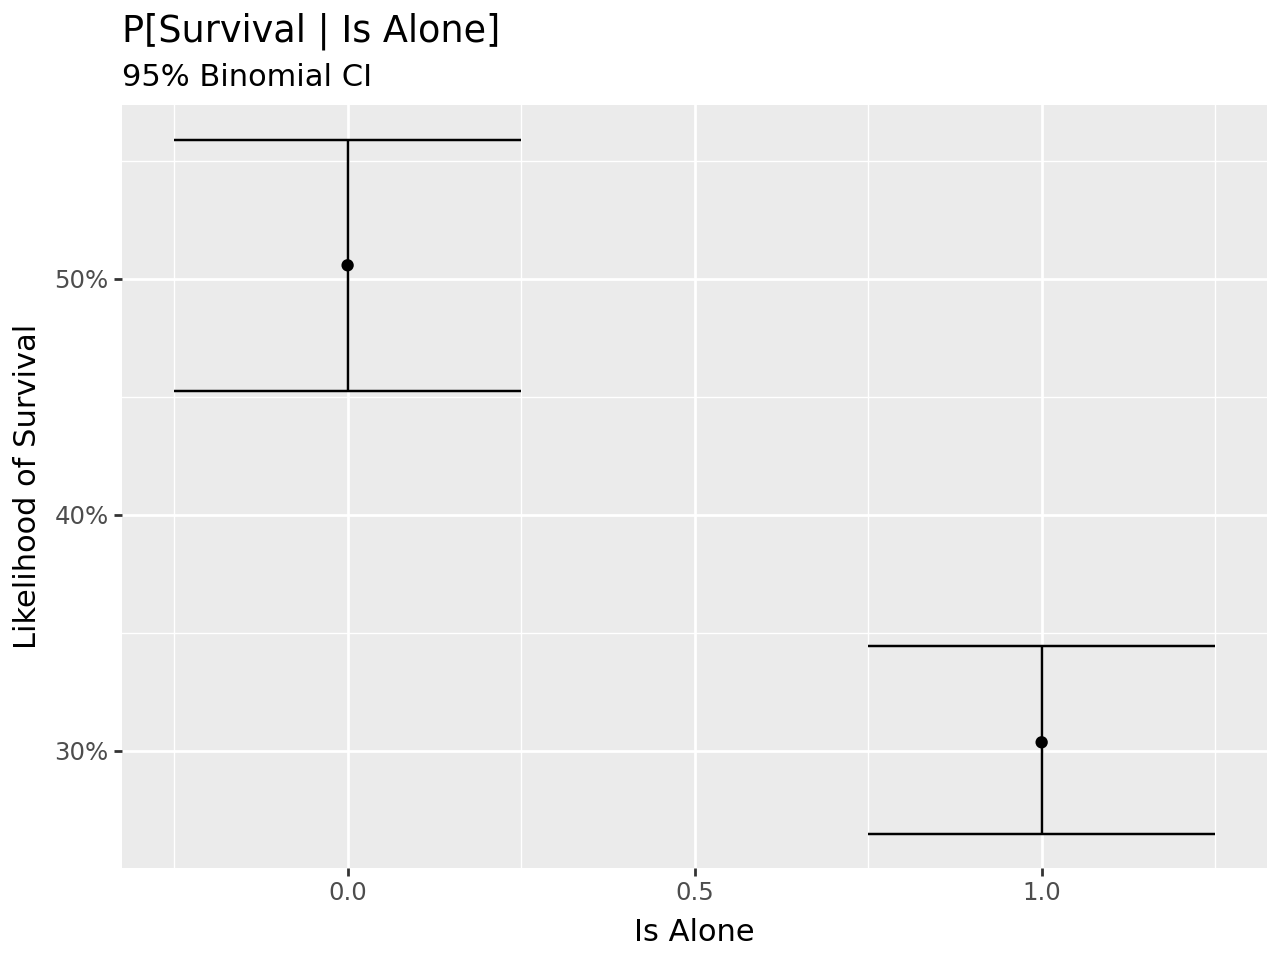

In [69]:
plot_survival_ci(is_alone_survival_rates, "is_alone").show()

### Ticket Fare

In [113]:
train_df.ticket_fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: ticket_fare, dtype: float64

In [119]:
from scipy.stats import boxcox
train_df = train_df.assign(boxcox_ticket_fare=boxcox(train_df.ticket_fare + 1)[0]) # Add 1 to avoid log(0), return first element of tuple
train_df.boxcox_ticket_fare.describe()

count    891.000000
mean       2.537799
std        0.718497
min        0.000000
25%        1.969136
50%        2.402007
75%        2.939543
max        4.671393
Name: boxcox_ticket_fare, dtype: float64

c:\Users\pwiss\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-conformal-prediction-uv6vZjWC-py3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


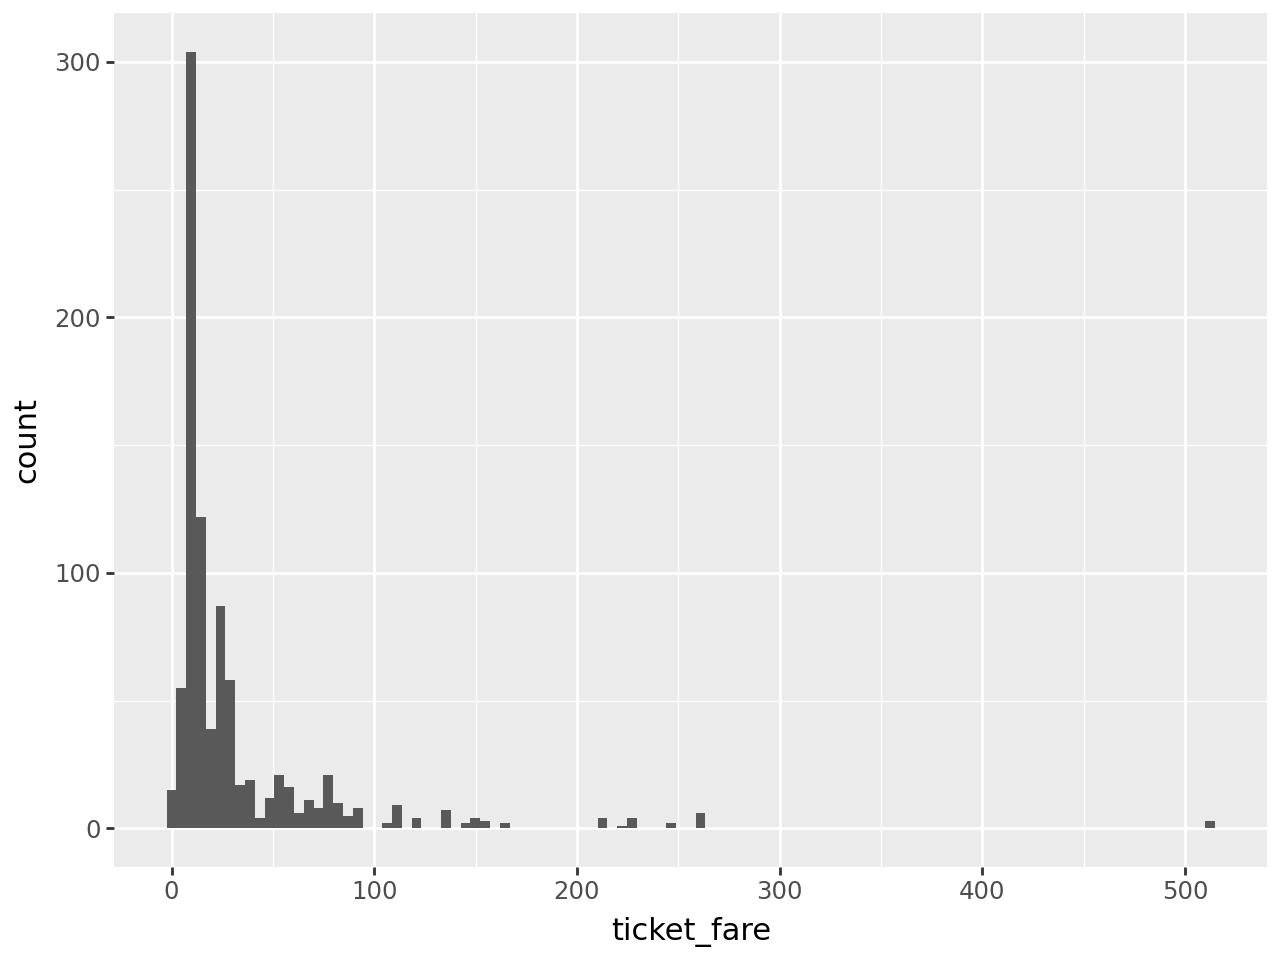

In [121]:
ggplot(train_df, aes(x="ticket_fare")) + geom_histogram()

c:\Users\pwiss\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-conformal-prediction-uv6vZjWC-py3.11\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


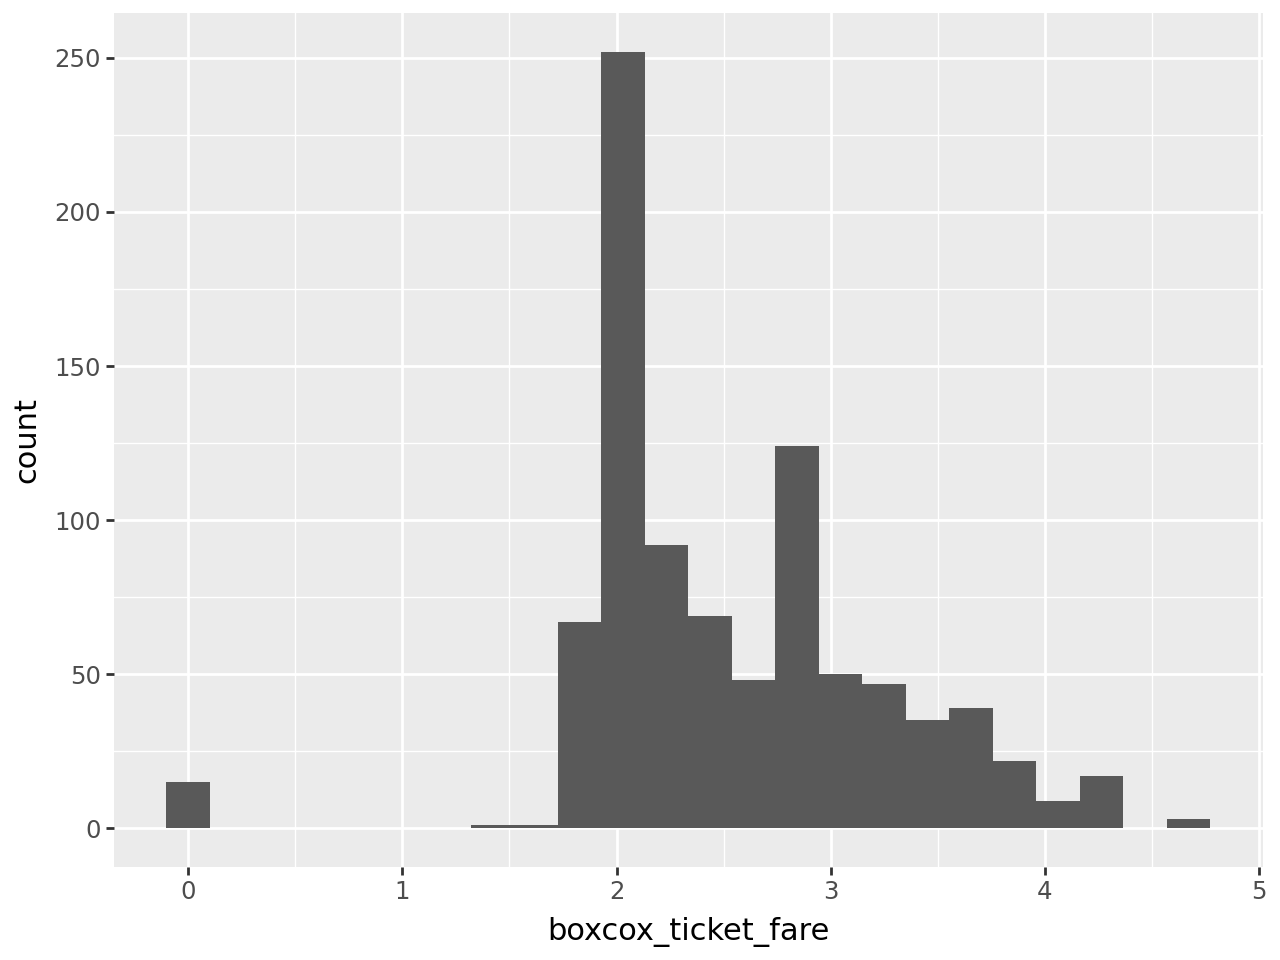

In [120]:
ggplot(train_df, aes(x="boxcox_ticket_fare")) + geom_histogram()

## Model Creation

### Feature Engineering

In [122]:
def create_new_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.assign(
        cabin_count=(
            df.cabin_number.str.split(" ", expand=True)
            .map(lambda x: 1 if not pd.isnull(x) else 0)
            .sum(axis=1)
        )
    )
    df = df.assign(
        young_child_or_not=pd.cut(df.age, bins=[0, 5, 100], labels=["young child", "not young child"]),
        clean_cabin_count=df.cabin_count.apply(lambda x: str(x) if x < 2 else "2-4"),
        family_size=df.sibling_spouse_count + df.parent_child_count,
        ticket_fare=boxcox(train_df.ticket_fare + 1)[0]
    )
    return (df.assign(
        demographic=df.apply(lambda x: x.sex if x.young_child_or_not != "young child" else x.young_child_or_not, axis=1),
        is_alone=df.family_size.map(lambda x: "alone" if x == 0 else "with family"),
        )
        .drop(columns=["cabin_count", "young_child_or_not", "sex", "family_size", "sibling_spouse_count", "parent_child_count"])
    )

In [123]:
train_df = pd.read_csv(train_path)
train_df = rename_columns(train_df)
train_df = create_new_features(train_df)
train_df

,passenger_id,did_survive,ticket_class,passenger_name,age,ticket_number,ticket_fare,cabin_number,embarkation_port,clean_cabin_count,demographic,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",22.0,A/5 21171,1.906724,NaN,S,0,male,with family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,PC 17599,3.497640,C85,C,1,female,with family
2,3,1,3,"Heikkinen, Miss. Laina",26.0,STON/O2. 3101282,1.970459,NaN,S,0,female,alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,113803,3.304258,C123,S,1,female,with family
4,5,0,3,"Allen, Mr. William Henry",35.0,373450,1.981680,NaN,S,0,male,alone
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,211536,2.326029,NaN,S,0,male,alone
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,112053,2.916885,B42,S,1,female,alone
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,W./C. 6607,2.745246,NaN,S,0,female,with family
889,890,1,1,"Behr, Mr. Karl Howell",26.0,111369,2.916885,C148,C,1,male,alone


### Model Creation

In [124]:
X_cols = [
    "ticket_class", # OrdinalEncoder
    "demographic", # OHE
    "clean_cabin_count", # OHE
    "is_alone", # OHE
    "ticket_fare", # Numeric Scaler
    "embarkation_port", # OHE
]
y_col = "did_survive"

ohe_cols = [
    "demographic",
    "clean_cabin_count",
    "is_alone",
    # "embarkation_port",
]
ordinal_cols = [
    "ticket_class",
]
numeric_cols = [
    "ticket_fare",
]

In [141]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

In [126]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[X_cols], train_df[y_col], test_size=0.2, random_state=42)

In [127]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), LogisticRegression())
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.776536312849162

In [128]:
column_transformer = ColumnTransformer([
    # ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), LogisticRegression())
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.7653631284916201

In [129]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    # ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), LogisticRegression())
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.7821229050279329

In [130]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    # ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), LogisticRegression())
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.6983240223463687

Overall, the encodings/scalings I've chosen seem decent.

In [140]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), RandomForestClassifier(n_estimators=100))
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.8044692737430168

In [137]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, SimpleImputer(strategy="most_frequent"), GradientBoostingClassifier(n_estimators=100))
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.8212290502793296

In [135]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(column_transformer, HistGradientBoostingClassifier())
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.8268156424581006

HistGradientBoostingClassifier worked best, let's apply `GridSearchCV` to it now and see if we can improve the performance.

In [151]:
column_transformer = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_cols),
    ("onehot", OneHotEncoder(), ohe_cols),
    ("standard", RobustScaler(), numeric_cols),
])
pipeline = make_pipeline(
    column_transformer,
    GridSearchCV(
        HistGradientBoostingClassifier(),
        param_grid={
            "max_iter": [100, 200, 300],
            "max_depth": [None, 5, 10],
            "learning_rate": [0.1, 0.01, 0.001],
            "scoring": ["accuracy", "roc_auc", "loss"],
        },
        cv=KFold(n_splits=10),
        refit=True
    ),
)
pipeline.fit(X_train, y_train)
accuracy_score(pipeline.predict(X_valid), y_valid)

0.8268156424581006

## Conclusions

Originally, I wanted to play around with conformal prediction in this workbook, but I decided to hold off and try on a different project. Really, this was just a little playground for me to mess around with ML in my free time, and hopefully to get my brain primed for working on other ML problems or data sets in Kaggle.

When looking at the leaderboard, what immediately stands out is that many people have obtained 100% accuracy on the validation data set. However, when doing research online, I've become skeptical that the leaderboard uses only the data supplied by Kaggle. I suspect that people went outside of Kaggle to grab extra data, such as was done here with Wikipedia data: https://github.com/RutvijBhutaiya/The-Famous-Titanic-Study/blob/master/README.md. In particular, he managed to get a "Lifeboat Support" column, which seems like it should massively impact the model, though I didn't spy any EDA on that particular feature.

Ultimately, this was a fun little project, but I would hardly call my results outstanding. Maybe further down the line I will revisit this and try improving the model.